# Image Classification from Scratch

**Task:** Train an image classifier from scratch on the Kaggle Cats vs Dogs binary classification dataset.

For this notebook, I used the following guide: https://keras.io/examples/vision/image_classification_from_scratch/. The `image_dataset_from_directory` utility is used to generate the datasets, and Keras image preprocessing layers are used for image standardization and data augmentation.


## Setup


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load the data: Cats vs Dogs Dataset

### Raw data download


In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   271M      0  0:00:02  0:00:02 --:--:--  271M


In [3]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [4]:
# `PetImages` folder contain two subfolders, `Cat` and `Dog`, which each have image files

!ls PetImages

Cat  Dog


### Filter out corrupted images


In [5]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 1590 images


## Generate a `Dataset`


In [6]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


## Visualize the data

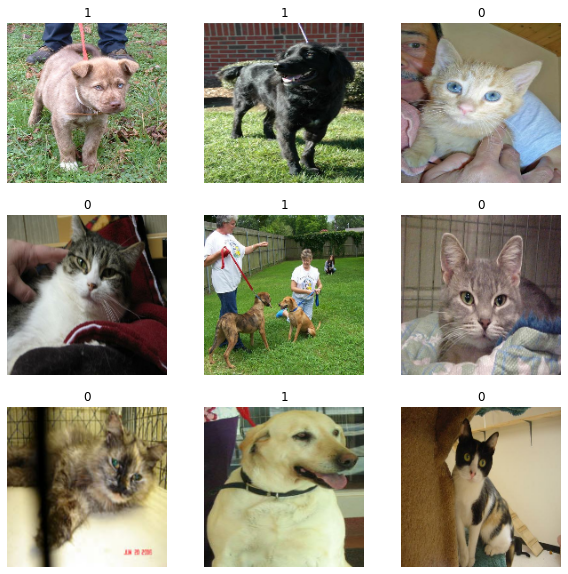

In [7]:
import matplotlib.pyplot as plt

# First 9 images in the training dataset
# label 1: "dog"; label 0: "cat"

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Image data augmentation

It is a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the
training images. This
helps expose the model to different aspects of the training data and slow down overfitting.

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

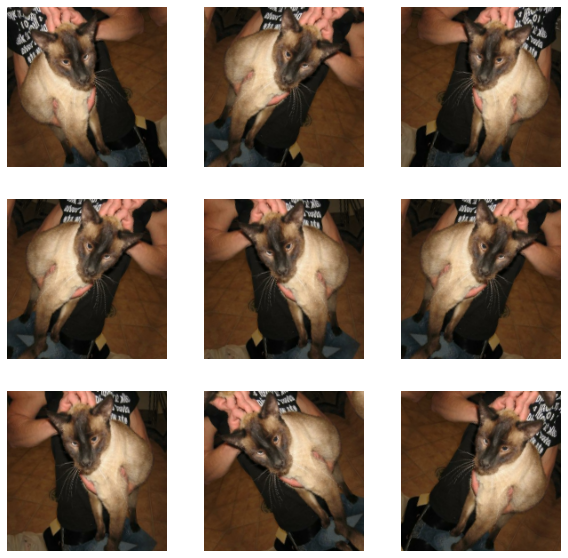

In [9]:
# visualize what the augmented samples look like by repeatedly applying data_augmentation to the first image

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Standardizing the data

Our images are already in a standard size (180x180), but their RGB channel values are in
 the `[0, 255]` range, which is not ideal for a neural network. To make the input values small, we 
standardize values to be in  `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


## Configure the dataset for performance


In [10]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Build a model

- Start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- Include a `Dropout` layer before the final classification layer.


In [11]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 32)   896         rescaling[0][0]                  
______________________________________________________________________________________________

## Train the model


In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

epochs = 15

history = model.fit( train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds )

Epoch 1/15
586/586 [==============================] - 161s 259ms/step - loss: 0.6935 - accuracy: 0.6172 - val_loss: 0.5636 - val_accuracy: 0.7136
Epoch 2/15
586/586 [==============================] - 153s 261ms/step - loss: 0.4727 - accuracy: 0.7774 - val_loss: 0.3722 - val_accuracy: 0.8372
Epoch 3/15
586/586 [==============================] - 153s 260ms/step - loss: 0.3745 - accuracy: 0.8314 - val_loss: 0.3872 - val_accuracy: 0.8411
Epoch 4/15
586/586 [==============================] - 152s 260ms/step - loss: 0.2842 - accuracy: 0.8799 - val_loss: 0.3438 - val_accuracy: 0.8488
Epoch 5/15
586/586 [==============================] - 153s 260ms/step - loss: 0.2302 - accuracy: 0.9018 - val_loss: 0.4471 - val_accuracy: 0.8234
Epoch 6/15
586/586 [==============================] - 153s 260ms/step - loss: 0.2069 - accuracy: 0.9136 - val_loss: 0.2852 - val_accuracy: 0.8757
Epoch 7/15
586/586 [==============================] - 152s 259ms/step - loss: 0.1930 - accuracy: 0.9170 - val_loss: 0.2066 -

We get to ~93% validation accuracy after training for 15 epochs on the full dataset.


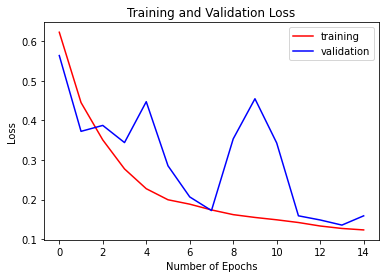

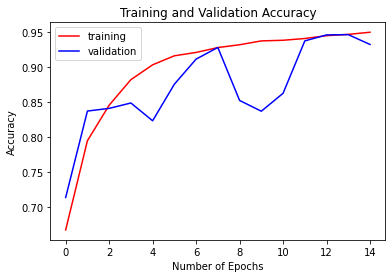

In [13]:
# Plot the loss and accuracy curves for training and validation 

import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(history.history['loss'], color='r', label="training")
plt.plot(history.history['val_loss'], color='b', label="validation")
plt.title("Training and Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('loss.png')
plt.show()

plt.figure(2)
plt.plot(history.history['accuracy'], color='r', label="training")
plt.plot(history.history['val_accuracy'], color='b', label="validation")
plt.title("Training and Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('acc.png')
plt.show()

## Run inference on new data

In [14]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 19.13 percent cat and 80.87 percent dog.
